### Importing libraries

In [14]:
import os
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import folium
from folium import plugins as folium_plugins

%matplotlib inline

# set floating point display format
pd.options.display.float_format = "{:.2f}".format

Clean and reformat data.

In [2]:
traffic_dfs = [pd.read_csv(os.path.join('data', f),
                           sep=';',
                           usecols=['Day',
                                    'Time',
                                    'Line',
                                    'Direction',
                                    'Stop name',
                                    'Stop number',
                                    'Passeng. in',
                                    'Passeng. out',
                                    'Tickets',
                                    'Pass. in [1]',
                                    'Pass. out [1]',
                                    'Pass. in [2]',
                                    'Pass. out [2]',
                                    'Pass. in [3]',
                                    'Pass. out [3]',
                                    'Pass. in [4]',
                                    'Pass. out [4]', ],
                           encoding='utf-8')
               for f in os.listdir('data') if f.endswith('csv') and not f.startswith('stops')]

traffic_df = pd.concat(traffic_dfs)
traffic_df['Passeng. in'] = traffic_df['Passeng. in'].fillna(0)
traffic_df['Passeng. out'] = traffic_df['Passeng. out'].fillna(0)
traffic_df['Pass. in [1]'] = traffic_df['Pass. in [1]'].fillna(0)
traffic_df['Pass. out [1]'] = traffic_df['Pass. out [1]'].fillna(0)
traffic_df['Pass. in [2]'] = traffic_df['Pass. in [2]'].fillna(0)
traffic_df['Pass. out [2]'] = traffic_df['Pass. out [2]'].fillna(0)
traffic_df['Pass. in [3]'] = traffic_df['Pass. in [3]'].fillna(0)
traffic_df['Pass. out [3]'] = traffic_df['Pass. out [3]'].fillna(0)
traffic_df['Pass. in [4]'] = traffic_df['Pass. in [4]'].fillna(0)
traffic_df['Pass. out [4]'] = traffic_df['Pass. out [4]'].fillna(0)

traffic_df['passengers_in'] = traffic_df['Passeng. in'] + \
                              traffic_df['Pass. in [1]'] + \
                              traffic_df['Pass. in [2]'] + \
                              traffic_df['Pass. in [3]'] + \
                              traffic_df['Pass. in [4]']

traffic_df['passengers_out'] = traffic_df['Passeng. out'] + \
                              traffic_df['Pass. out [1]'] + \
                              traffic_df['Pass. out [2]'] + \
                              traffic_df['Pass. out [3]'] + \
                              traffic_df['Pass. out [4]']

traffic_df['passengers_in'] = traffic_df['passengers_in'].astype('int64')
traffic_df['passengers_out'] = traffic_df['passengers_out'].astype('int64')

traffic_df['datetime'] = pd.to_datetime(traffic_df['Day'] + ' ' + traffic_df['Time'])

traffic_df = traffic_df.drop(['Passeng. in',
                              'Passeng. out',
                              'Pass. in [1]',
                              'Pass. out [1]',
                              'Pass. in [2]',
                              'Pass. out [2]',
                              'Pass. in [3]',
                              'Pass. out [3]',
                              'Pass. in [4]',
                              'Pass. out [4]',
                              'Day',
                              'Time',
                              'Tickets',
                              'Stop name'], axis=1)

traffic_df = traffic_df.rename(columns={'Direction': 'direction', 
                                        'Stop number': 'stop_number',
                                        'Line': 'line'})

display(traffic_df.describe())

,stop_number,passengers_in,passengers_out
count,5529409.00,5529409.00,5529409.00
mean,1994.36,0.15,1.52
std,1735.79,1128.17,1702.94
min,0.00,-999996.00,-999997.00
25%,913.00,0.00,0.00
50%,1918.00,0.00,0.00
75%,2630.00,2.00,2.00
max,65534.00,1231.00,1000013.00


After inspecting data statistics we can see some abnormal values: passengers_in between -999996 and 1231, passengers_out between -999997 and 1000013. All abnormal data are removed leaving passengers in/out numbers between 0 and 20. After that I remove rows that has no meaningful information (in and out equal to 0).

In [3]:
traffic_df = traffic_df[(traffic_df['passengers_in'] >= 0) & (traffic_df['passengers_in'] <= 20)]
traffic_df = traffic_df[(traffic_df['passengers_out'] >= 0) & (traffic_df['passengers_out'] <= 20)]

traffic_df = traffic_df[~((traffic_df['passengers_in'] == 0) & (traffic_df['passengers_out'] == 0))]

display(traffic_df.describe())

,stop_number,passengers_in,passengers_out
count,3352186.00,3352186.00,3352186.00
mean,1935.27,2.55,2.63
std,1539.36,3.22,3.35
min,0.00,0.00,0.00
25%,803.00,0.00,0.00
50%,1902.00,1.00,1.00
75%,2415.00,3.00,4.00
max,65534.00,20.00,20.00


Now passengers traffic data looks OK. Time to prepare stops data.

In [4]:
def str_2_int(string, default=None):
    try:
        return int(string)
    except ValueError:
        return default


stop_df = pd.read_csv(os.path.join('data', 'stops_coordinates.csv'),
                      sep=',',
                      quotechar='"')

stop_df = stop_df.rename(columns={'Stop number': 'stop_number',
                                  'Stop name': 'stop_name',
                                  'Lng': 'lng',
                                  'Lat': 'lat'})

display(stop_df.dtypes)
display(stop_df.describe())

stop_number     object
stop_name       object
lng            float64
lat            float64
dtype: object

,lng,lat
count,1479.00,1479.00
mean,25.27,54.69
std,0.08,0.05
min,25.03,54.56
25%,25.22,54.67
50%,25.27,54.69
75%,25.32,54.72
max,25.52,54.83


Stop number field in stop data is of type string (contains strings "1002a", "101b") and in passengers traffic data field type is integer. Cause I am planning to join those two data frames, using stop number field I have to make those fields the same type (integer). Stop number of string type never appiered in passengers traffic data so stops with stop number field of type string where removed from stops dataframe.

In [5]:
stop_df['stop_number'] = stop_df['stop_number'].apply(str_2_int)
stop_df = stop_df[stop_df['stop_number'].notnull()]

stop_df['stop_number'] = stop_df['stop_number'].astype('int64')

display(stop_df.dtypes)
display(stop_df.describe())

stop_number      int64
stop_name       object
lng            float64
lat            float64
dtype: object

,stop_number,lng,lat
count,1408.00,1408.00,1408.00
mean,2432.26,25.27,54.69
std,1409.81,0.08,0.05
min,101.00,25.03,54.56
25%,1317.75,25.22,54.67
50%,2317.50,25.27,54.69
75%,3517.25,25.32,54.73
max,5300.00,25.46,54.83


I have two separate dataframes, need to join them to have on dataframe that I am going to analyze.

In [6]:
df = pd.merge(traffic_df, stop_df, on='stop_number')

display(df.dtypes)
display(df.describe())

line                      object
direction                 object
stop_number                int64
passengers_in              int64
passengers_out             int64
datetime          datetime64[ns]
stop_name                 object
lng                      float64
lat                      float64
dtype: object

,stop_number,passengers_in,passengers_out,lng,lat
count,3191772.00,3191772.00,3191772.00,3191772.00,3191772.00
mean,2008.38,2.56,2.64,25.27,54.70
std,1309.04,3.21,3.33,0.06,0.04
min,101.00,0.00,0.00,25.09,54.58
25%,916.00,0.00,0.00,25.23,54.68
50%,1912.00,1.00,1.00,25.27,54.70
75%,2624.00,4.00,4.00,25.29,54.73
max,5206.00,20.00,20.00,25.44,54.82


Something weird before join I had 5484429 records, after joi 5197911.

In [7]:
tmp_df = traffic_df[~traffic_df['stop_number'].isin(stop_df['stop_number'])]
display(tmp_df.head())

,line,direction,stop_number,passengers_in,passengers_out,datetime
782,103,GER.VILTIES-SANTARIS,589,5,4,2016-08-28 00:11:25
789,74,STOTIS-SUBACIAUS-AP,587,1,0,2016-08-31 00:11:47
896,101,AP-SAULETEKIS,824,1,0,2016-08-21 00:14:46
903,23,STOTIS-OLANDU G.-AP,584,2,0,2016-08-18 00:14:58
918,103,GER.VILTIES-SANTARIS,589,1,0,2016-08-13 00:15:29


It seems that some passengers trafic data are still incorrect (stop number not exists in stops dataframe), so after join those incorrect values are removed.

In [8]:
df = df[['direction', 
         'line', 
         'stop_number', 
         'stop_name', 
         'passengers_in', 
         'passengers_out', 
         'lat', 
         'lng', 
         'datetime']]

display(df.head())

,direction,line,stop_number,stop_name,passengers_in,passengers_out,lat,lng,datetime
0,MARKUCIAI-FABIJONISK,10,3819,Liudo Giros st.,0,3,54.73,25.25,2016-08-19 00:00:03
1,MARKUCIAI-FABIJONISK,10,3819,Liudo Giros st.,0,1,54.73,25.25,2016-08-21 00:09:49
2,AP-ZVALGU G.-TARANDE,52,3819,Liudo Giros st.,1,0,54.73,25.25,2016-08-01 05:11:19
3,VAIKU LIGON-STOTIS,2G,3819,Liudo Giros st.,1,0,54.73,25.25,2016-08-20 05:31:24
4,AP-ZVALGU-FABIJONISK,10,3819,Liudo Giros st.,0,1,54.73,25.25,2016-08-25 05:38:34


First of all lets view passengers in/out count by month. To do that I need to group data by month and sum in/out numbers.

In [9]:
traffic_by_month_df = df[['datetime', 'passengers_in', 'passengers_out']].resample('M', on='datetime').sum()
traffic_by_month_df.index = traffic_by_month_df.index.strftime('%Y-%m')
traffic_by_month_df.index.name = 'datetime'
display(traffic_by_month_df.head())

,passengers_in,passengers_out
datetime,,
2016-01,660906,689935
2016-02,684491,713276
2016-03,690116,717042
2016-04,695794,718885
2016-05,755274,775656


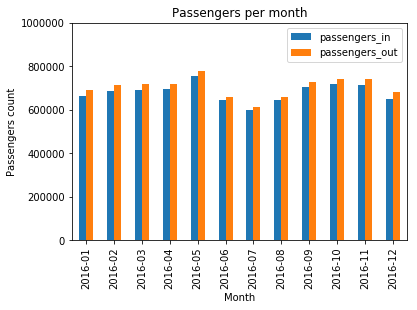

In [10]:
ax = traffic_by_month_df.plot(kind='bar')
ax.set_xlabel('Month')
ax.set_ylabel('Passengers count')
ax.set_title('Passengers per month')
ax.set_ylim(0, 1000000)
plt.show()

Usage of Vilnius public transport rises till May, then it starts to decrease and after the summer, from August it starts to increase again. Number of passengers in and out are different, it may be because automatic passangers counters that are using in buses are not accurate.


Lets plot passengers flow heatmap. To do that i need group data by month and stop.

In [32]:
traffic_by_stop_df = df.groupby([df['datetime'].dt.strftime('%m'), df['lat'], df['lng']])['passengers_in', 'passengers_out'].sum().reset_index()
traffic_by_stop_df = traffic_by_stop_df.rename(columns={'datetime': 'month'})
display(traffic_by_stop_df.head())

,month,lat,lng,passengers_in,passengers_out
0,01,54.58,25.20,477,470
1,01,54.58,25.20,18,217
2,01,54.58,25.21,50,4
3,01,54.59,25.21,12,24
4,01,54.59,25.21,26,1


In [35]:
map_vilnius = folium.Map(location=[54.685010, 25.274211], zoom_start = 12)
heat_data = [[[row['lat'], row['lng'], row['passengers_in']] for index, row in traffic_by_stop_df[traffic_by_stop_df['month'] == str(i).zfill(2)].iterrows()] for i in range(1, 13)]

heatmap = folium_plugins.HeatMapWithTime(heat_data,
                                        min_opacity=0.4,
                                        radius=15)

map_vilnius.add_child(heatmap)
    
map_vilnius